In [29]:
pip install blueprints.exploration 

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement blueprints.exploration (from versions: none)
ERROR: No matching distribution found for blueprints.exploration


In [36]:
pip install textacy

  Using cached textacy-0.13.0-py3-none-any.whl (210 kB)
     ---------------------------------------- 12.3/12.3 MB 6.5 MB/s eta 0:00:00
  Using cached floret-0.10.3-cp39-cp39-win_amd64.whl (233 kB)
  Using cached pyphen-0.14.0-py3-none-any.whl (2.0 MB)
  Using cached spacy_loggers-1.0.4-py3-none-any.whl (11 kB)
  Using cached thinc-8.1.10-cp39-cp39-win_amd64.whl (1.5 MB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl (29 kB)
  Using cached murmurhash-1.0.9-cp39-cp39-win_amd64.whl (18 kB)
     ------------------------------------- 483.6/483.6 kB 10.1 MB/s eta 0:00:00
  Using cached cymem-2.0.7-cp39-cp39-win_amd64.whl (30 kB)
  Using cached pathy-0.10.2-py3-none-any.whl (48 kB)
  Using cached preshed-3.0.8-cp39-cp39-win_amd64.whl (96 kB)
  Using cached typer-0.9.0-py3-none-any.whl (45 kB)
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached wasabi-1.1.2-py3-none-any.whl (27 kB)
     ---------------------------------------- 7.4/7.4 MB 8.3 MB/s eta 0:00:00
Note:

In [125]:
pip install fasttext

Note: you may need to restart the kernel to use updated packages.Collecting fasttext
  Using cached fasttext-0.9.2.tar.gz (68 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for fasttext
Failed to build fasttext
  Running setup.py install for fasttext: started
  Running setup.py install for fasttext: finished with status 'error'



  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      c:\Users\LG\anaconda3\lib\site-packages\setuptools\dist.py:771: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
        warnings.warn(
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-39
      creating build\lib.win-amd64-cpython-39\fasttext
      copying python\fasttext_module\fasttext\FastText.py -> build\lib.win-amd64-cpython-39\fasttext
      copying python\fasttext_module\fasttext\__init__.py -> build\lib.win-amd64-cpython-39\fasttext
      creating build\lib.win-amd64-cpython-39\fasttext\util
      copying python\fasttext_module\fasttext\util\util.py -> build\lib.win-amd64-cpython-39\fasttext\util
      copying python\fasttext_module\fasttext\ut

In [127]:
import tensorflow as tf
import pandas as pd
import sqlite3
import re
from collections import Counter
from tqdm import tqdm
tqdm.pandas()
import html
import textacy
import textacy.preprocessing as tprep
from textacy.preprocessing.resources import RE_URL
import nltk
import spacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
from spacy.lang.en import English
from spacy import displacy
from gensim.models import FastText

### GPU 설정

In [84]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0' : 
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [85]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16307135172732124601
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2258003559
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12847164992737909720
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


#### 데이터 로드하기

In [4]:
post_df = pd.read_csv('./data/rspct_autos.tsv.gz', sep='\t')
subred_file = pd.read_csv('./data/subreddit_info.csv.gz').set_index(['subreddit'])

df = post_df.join(subred_file, on='subreddit')

In [5]:
df.head()

,id,subreddit,title,selftext,category_1,category_2,category_3,in_data,reason_for_exclusion
0,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson,NaN,True,NaN
1,5s0q8r,Mustang,Roush vs Shleby GT500,"I am trying to determine which is faster, and ...",autos,ford,NaN,True,NaN
2,5z3405,Volkswagen,2001 Golf Wagon looking for some insight,Hello! <lb><lb>Trying to find some information...,autos,VW,NaN,True,NaN
3,7df18v,Lexus,IS 250 Coolant Flush/Change,https://www.cars.com/articles/how-often-should...,autos,lexus,NaN,True,NaN
4,5tpve8,volt,Gen1 mpg w/ dead battery?,"Hi, new to this subreddit. I'm considering bu...",autos,chevrolet,NaN,True,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    20000 non-null  object
 1   subreddit             20000 non-null  object
 2   title                 20000 non-null  object
 3   selftext              20000 non-null  object
 4   category_1            20000 non-null  object
 5   category_2            20000 non-null  object
 6   category_3            0 non-null      object
 7   in_data               20000 non-null  bool  
 8   reason_for_exclusion  0 non-null      object
dtypes: bool(1), object(8)
memory usage: 1.2+ MB


In [7]:
df['in_data'].value_counts()

True    20000
Name: in_data, dtype: int64

#### 속성 이름 표준화

In [8]:
# 열 목록 확인하기
print(df.columns)

Index(['id', 'subreddit', 'title', 'selftext', 'category_1', 'category_2',
       'category_3', 'in_data', 'reason_for_exclusion'],
      dtype='object')


In [9]:
# 현재 열 이름 새 이름으로 매핑하기
# None으로 매핑된 열과 언급되지 않은 열은 삭제됨.
column_mapping = {
    'id': 'id',
    'subreddit': 'subreddit',
    'title': 'title',
    'selftext': 'text',
    'category_1': 'category',
    'category_2': 'subcategory',
    'category_3': None,           # 데이터가 없다.
    'in_data': None,              # 필요없다.
    'reason_for_exclusion': None  # 필요없다.
}

# 나머지 열들을 정의하기
columns = [c for c in column_mapping.keys() if column_mapping[c] != None]

# 열들을 선택하고 이름 바꾸기
df = df[columns].rename(columns=column_mapping)

In [10]:
df.head()

,id,subreddit,title,text,category,subcategory
0,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson
1,5s0q8r,Mustang,Roush vs Shleby GT500,"I am trying to determine which is faster, and ...",autos,ford
2,5z3405,Volkswagen,2001 Golf Wagon looking for some insight,Hello! <lb><lb>Trying to find some information...,autos,VW
3,7df18v,Lexus,IS 250 Coolant Flush/Change,https://www.cars.com/articles/how-often-should...,autos,lexus
4,5tpve8,volt,Gen1 mpg w/ dead battery?,"Hi, new to this subreddit. I'm considering bu...",autos,chevrolet


In [11]:
# 데이터를 자동차 범주로 제한하기
df = df[df['category'] == 'autos']

In [12]:
# pd.options.display.max_colwidth = None ###
pd.options.display.max_colwidth = 100 ###
df.sample(1, random_state=7).T

,14356
id,7jc2k4
subreddit,volt
title,Dashcam for 2017 volt
text,Hello.<lb>I'm looking into getting a dashcam. <lb>Does anyone have any recommendations? <lb><lb>...
category,autos
subcategory,chevrolet


#### 데이터프레임 저장 및 로드

In [13]:
df.to_pickle('reddit_dataframe.pkl')

In [14]:
db_name = 'reddit-selfposts.db'
con = sqlite3.connect(db_name)
df.to_sql('post', con, index=False, if_exists='replace')
con.close()

In [15]:
# 데이터 프레임 복원하기
con = sqlite3.connect(db_name)
df = pd.read_sql('select * from post', con)
con.close()

### 텍스트 데이터 정리

#### 정규 표현식으로 노이즈 식별

In [16]:
text = """
After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>"""

In [17]:
print(text)


After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>


In [18]:
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len = 10) : 
    '''텍스트에서 의심스러운 문자의 비율을 반환'''
    if text == None or len(text) < min_len : 
        return 0 
    else : 
        return len(RE_SUSPICIOUS.findall(text)) / len(text)
    
print(impurity(text))

0.09009009009009009


In [19]:
# 데이터프레임에 새 열 추가하기
df['impurity'] = df['text'].apply(impurity, min_len=10)

# 상위 3개 레코드 가져오기
df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,text,impurity
19682,Looking at buying a 335i with 39k miles and 11 months left on the CPO warranty. I asked the deal...,0.214716
12357,I'm looking to lease an a4 premium plus automatic with the nav package.<lb><lb>Vehicle Price:<ta...,0.165099
2730,Breakdown below:<lb><lb>Elantra GT<lb><lb>2.0L 4-cylinder<lb><lb>6-speed Manual Transmission<lb>...,0.139130


##### count_words 구현

In [20]:
def count_words(df, column='tokens', preprocess=None, min_freq=2) : 
    # 토큰 처리 및 counter 업데이트
    def update(doc) : 
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # counter생성 및 모든 데이터에서 적용
    counter = Counter()
    df[column].progress_map(update)

    # counter를 데이터프레임으로 전달(transform)
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

In [21]:
# 정규 표현식으로 다른 태그가 있는지 확인하기
# <[\w/]*> : HTML과 유사한 구문 찾기(알파벳, 숫자, 밑줄 또는 /(슬래시)중 하나 찾기)
count_words(df, column='text', preprocess=lambda t: re.findall(r'<[\w/]*>', t))

100%|██████████| 20000/20000 [00:00<00:00, 145856.87it/s]


,freq
token,
<lb>,100729
<tab>,642


#### 정규 표현식으로 노이즈 제거

In [22]:
def clean(text) : 
    # &amp와 같은 html 이스케이프를 문자로 변환한다.
    text = html.unescape(text)
    # <tap>과 같은 태그를 공백으로 변환하기
    text = re.sub(r'<[^<>]*>', ' ', text)
    # [Some text](https://...)와 같은 마크다운 URL을 공백으로 변환한다.
    # r'\1 : 첫 번째 그룹에 일치하는 내용 반환
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # [0]과 같은 괄호 안의 텍스트 또는 코드를 공백으로 변환한다.
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # 특수 문자로만 구성된 문자열을 공백으로 변환한다. 
    # &#은 변환되지만 #cool은 변환되지 않음.
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # --- 또는 == 같은 하이픈으로 이뤄진 문자열을 공백으로 변환한다.
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:$|\s)', ' ', text)
    # 연속된 공백을 공백 하나로 변환한다.
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [23]:
# 샘플 텍스트에 clean함수 적용하고 결과 확인해보기
clean_text = clean(text)
print(clean_text)
print('Impurity:', impurity(clean_text))

After viewing the PINKIEPOOL Trailer it got me thinking about the best match ups. Here's my take: Deadpool Captain America
Impurity: 0.0


In [24]:
# 정리된 텍스트 불순물을 다시 확인하고 
# 필요하면 정리 단계 추가로 시행
df['clean_text'] = df['text'].map(clean)
df['impurity'] = df['clean_text'].apply(impurity, min_len=20)
df[['clean_text','impurity']].sort_values(by='impurity', ascending=False).head(3)

,clean_text,impurity
14058,"Mustang 2018, 2019, or 2020? Must Haves!! 1. Have a Credit score of 780\+ for the best low inter...",0.030864
18934,"At the dealership, they offered an option for foot-well illumination, but I cannot find any refe...",0.026455
16505,"I am looking at four Caymans, all are in a similar price range. The major differences are the mi...",0.024631


#### textacy를 사용한 문자 정규화

In [25]:
text = "The café “Saint-Raphaël” is loca-\nted on Côte dʼAzur."

In [26]:
# 다양한 하이픈과 따옴표를 표준화하고 악센트를 제거함
def normalize(text) : 
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

In [27]:
print(normalize(text))

The cafe "Saint-Raphael" is located on Cote d'Azur.


#### textacy를 사용한 패턴 기반 데이터 마스킹

In [28]:
# 말뭉치에서 가장 자주 사용되는 url 찾기
count_words(df, column='clean_text', preprocess=RE_URL.findall).head(3)

100%|██████████| 20000/20000 [00:01<00:00, 18584.73it/s]


,freq
token,
www.getlowered.com,3
http://www.ecolamautomotive.com/#!2/kv7fq,2
https://www.reddit.com/r/Jeep/comments/4ux232/just_ordered_an_android_head_unit_joying_jeep/,2


In [29]:
if textacy.__version__ < '0.11':
    # as in book
    replace_urls = textacy.preprocessing.replace_urls
else:
    replace_urls = textacy.preprocessing.replace.urls

In [30]:
text = "Check out https://spacy.io/usage/spacy-101"

# 대체할 때 대체값으로 _URL_을 사용한다.
print(replace_urls(text))

Check out _URL_


In [31]:
# 정규화 및 데이터 마스킹 기능을 데이터에 적용하기
df['clean_text'] = df['clean_text'].map(replace_urls)
df['clean_text'] = df['clean_text'].map(normalize)

In [32]:
df.rename(columns={'text':'raw_text', 'clean_text':'text'}, inplace=True)
df.drop(columns=['impurity'], inplace=True)

In [33]:
# 데이터베이스에 저장
con = sqlite3.connect(db_name)
df.to_sql('post_cleaned', con, index=False, if_exists='replace')
con.close()

In [34]:
df.head()

,id,subreddit,title,raw_text,category,subcategory,text
0,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling ...,autos,harley davidson,Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling ...
1,5s0q8r,Mustang,Roush vs Shleby GT500,"I am trying to determine which is faster, and I've seen the dealership video with the two racing...",autos,ford,"I am trying to determine which is faster, and I've seen the dealership video with the two racing..."
2,5z3405,Volkswagen,2001 Golf Wagon looking for some insight,Hello! <lb><lb>Trying to find some information on replacing a 2001 Golf Wagon starter (gas).... ...,autos,VW,Hello! Trying to find some information on replacing a 2001 Golf Wagon starter (gas).... mine's g...
3,7df18v,Lexus,IS 250 Coolant Flush/Change,https://www.cars.com/articles/how-often-should-i-change-engine-coolant-1420680853669/<lb><lb>I h...,autos,lexus,_URL_ I have a IS 250 AWD from 2006. About 73K miles on it. I've never touched the engine radiat...
4,5tpve8,volt,Gen1 mpg w/ dead battery?,"Hi, new to this subreddit. I'm considering buying a Gen1 Volt, but I can't find any straight an...",autos,chevrolet,"Hi, new to this subreddit. I'm considering buying a Gen1 Volt, but I can't find any straight ans..."


### 토큰화

In [35]:
text = """
2019-08-10 23:32: @pete/@louis - I don't have a well-designed 
solution for today's problem. The code of module AC68 should be -1. 
Have to think a bit... #goodnight ;-) 😩😬"""

#### 정규 표현식을 사용한 토큰화

In [36]:
tokens = re.findall(r'\w\w+', text)
print(*tokens, sep='|')

2019|08|10|23|32|pete|louis|don|have|well|designed|solution|for|today|problem|The|code|of|module|AC68|should|be|Have|to|think|bit|goodnight


In [37]:
# 이모티콘도 토큰화에 포함시키기
RE_TOKEN = re.compile(r'''
                      ([#]?[@\w''\.\-\:]*\w       # 단어, 해시태크, 이메일 주소
                      | [:;<]\-[\)\(3]            # 폭넓게 설정한 기본 텍스트 이모지의 패턴
                      | [\U0001F1000-\U0001FFFF]  # 폭넓게 설정한 이모지의 유니코드 범위
                      )
                      ''', re.VERBOSE)

def tokenize(text) : 
    return RE_TOKEN.findall(text)

tokens = tokenize(text)
print(*tokens, sep='|')

2019-08-10|23:32|:|@pete|@louis|I|don't|have|a|well-designed|solution|for|today's|problem|The|code|of|module|AC68|should|be|-1|Have|to|think|a|bit|#goodnight|;-)|😩|😬


#### NLTK를 사용한 토큰화

In [38]:
tokens = nltk.tokenize.word_tokenize(text)
print(*tokens, sep='|')

2019-08-10|23:32|:|@|pete/|@|louis|-|I|do|n't|have|a|well-designed|solution|for|today|'s|problem|.|The|code|of|module|AC68|should|be|-1|.|Have|to|think|a|bit|...|#|goodnight|;|-|)|😩😬


In [39]:
# Regex Tokenizer
# RegexpTokenizer : re.findall()의 래퍼
tokenizer = nltk.tokenize.RegexpTokenizer(RE_TOKEN.pattern, flags=re.VERBOSE)
tokens = tokenizer.tokenize(text)
print(*tokens, sep='|')


2019-08-10|23:32|:|@pete|@louis|I|don't|have|a|well-designed|solution|for|today's|problem|The|code|of|module|AC68|should|be|-1|Have|to|think|a|bit|#goodnight|;-)|😩|😬


In [40]:
# Toktok Tokenizer : 다국어 관련 작업
tokenizer = nltk.tokenize.ToktokTokenizer()
tokens = tokenizer.tokenize(text)
print(*tokens, sep='|')

2019-08-10|23|:|32|:|@pete/@louis|-|I|don|'|t|have|a|well-designed|solution|for|today|'|s|problem.|The|code|of|module|AC68|should|be|-1.|Have|to|think|a|bit|...|#goodnight|;|-|)|😩😬


### 스페이시를 활용한 언어 처리

#### 파이프라인 인스턴스화

In [41]:
nlp = spacy.load('en_core_web_sm')

In [42]:
# 파이프라인 구성요소 확인하기
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x1c6ade830a0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x1c6ade83520>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x1c6b2e923c0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x1c6b30e3c40>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x1c6b30f3880>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x1c6afbfed60>)]

In [43]:
# 파서 및 개체명 인식 비활성화
# 토큰화만 원하면 텍스트에서 nlp.make_doc 호출
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#### 텍스트 처리

In [44]:
nlp = spacy.load('en_core_web_sm')
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

In [45]:
for token in doc : 
    print(token, end='|')

My|best|friend|Ryan|Peters|likes|fancy|adventure|games|.|

In [46]:
# 토큰과 그 속성을 포함하는 테이블 생성하는 함수
# lemma : 원형과 관련
def display_nlp(doc, include_punct=False) : 
    '''스페이시 토큰들의 시각화를 위한 데이터프레임 생성하기'''
    rows = []
    for i, t in enumerate(doc) : 
        if not t.is_punct or include_punct : 
            row = {'token':i, 'text':t.text, 'lemma_':t.lemma_,
                   'is_stop':t.is_stop, 'is_alpha':t.is_alpha,
                   'pos_':t.pos_, 'dep_':t.dep_,
                   'ent_type':t.ent_type_, 'ent_iob':t.ent_iob_}
            rows.append(row)

    df = pd.DataFrame(rows).set_index('token')
    df.index.name = None
    return df

In [47]:
display_nlp(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,ent_type,ent_iob
0,My,my,True,True,PRON,poss,,O
1,best,good,False,True,ADJ,amod,,O
2,friend,friend,False,True,NOUN,nsubj,,O
3,Ryan,Ryan,False,True,PROPN,compound,PERSON,B
4,Peters,Peters,False,True,PROPN,appos,PERSON,I
5,likes,like,False,True,VERB,ROOT,,O
6,fancy,fancy,False,True,ADJ,amod,,O
7,adventure,adventure,False,True,NOUN,compound,,O
8,games,game,False,True,NOUN,dobj,,O


#### 사용자 전략 토큰화

In [48]:
# 예시
text = "@Pete: choose low-carb #food #eat-smart. _url_ ;-) 😋👍"
doc = nlp(text)

for token in doc : 
    print(token, end='|')

@Pete|:|choose|low|-|carb|#|food|#|eat|-|smart|.|_|url|_|;-)|😋|👍|

In [49]:
# 중위, 접두사, 접미사 분할에 대한 개별 규칙 적용 함수
def custom_tokenizer(nlp) : 
    # re.search와 일치하는 패턴을 제외하고 기본 패턴을 사용한다.
    prefixes = [pattern for pattern in nlp.Defaults.prefixes 
                if pattern not in ['-', '_', '#']]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes
                if pattern not in ['_']]
    infixes  = [pattern for pattern in nlp.Defaults.infixes
                if not re.search(pattern, 'xx-xx')]

    return Tokenizer(vocab          = nlp.vocab, 
                     rules          = nlp.Defaults.tokenizer_exceptions,
                     prefix_search  = compile_prefix_regex(prefixes).search,
                     suffix_search  = compile_suffix_regex(suffixes).search,
                     infix_finditer = compile_infix_regex(infixes).finditer,
                     token_match    = nlp.Defaults.token_match)

In [50]:
nlp = spacy.load('en_core_web_sm')
nlp.tokenizer = custom_tokenizer(nlp)

In [51]:
doc = nlp(text)
for token in doc : 
    print(token, end='|')

@Pete|:|choose|low-carb|#food|#eat-smart|.|_url_|;-)|😋|👍|

#### 불용어 제거

In [52]:
text = "Dear Ryan, we need to sit down and talk. Regards, Pete"
doc = nlp(text)

non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Dear, Ryan, need, sit, talk, Regards, Pete]


In [53]:
nlp = spacy.load('en_core_web_sm')
nlp.vocab['down'].is_stop = False
nlp.vocab['Dear'].is_stop = True
nlp.vocab['Regrads'].is_stop = True

In [54]:
text = "Dear Ryan, we need to sit down and talk. Regards, Pete"
doc = nlp(text)

non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Ryan, need, sit, down, talk, Regards, Pete]


##### 해당 언어 클래스의 하위 클래스를 생성하고 거기에 자신의 불용어 목록 만들기(스페이시 3.0)

In [55]:
excluded_stop_words = {'down'}
included_stop_words = {'dear','regards'}

class CustomEnglishDefaults(English.Defaults) : 
    stop_words = English.Defaults.stop_words.copy()
    stop_words -= excluded_stop_words
    stop_words |= included_stop_words # |= : in place set연산자(합집합을 구한 후 원래 집합에 결과 할당)

class CustomEnglish(English) : 
    Defaults = CustomEnglishDefaults

nlp = CustomEnglish()

text = 'Dear Ryan, we need to sit down and talk. Regards, Pete'
doc = nlp.make_doc(text)  # only tokenize

tokens_wo_top = [token for token in doc]
for token in doc : 
    if not token.is_stop and not token.is_punct : 
        print(token, end='|')

Ryan|need|sit|down|talk|Pete|

In [56]:
# reset nlp to original
nlp = spacy.load('en_core_web_sm')

#### 품사 기반 원형 추출

In [57]:
# 원형 복원 : lemma_속성으로 접근 가능
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

print(*[t.lemma_ for t in doc], sep='|')

my|good|friend|Ryan|Peters|like|fancy|adventure|game|.


In [58]:
# 문서에 명사와 고유명사만 있는 목록 생성하기
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

nouns = [t for t in doc if t.pos_ in ['NOUN','PROPN']]
print(nouns)

[friend, Ryan, Peters, adventure, games]


In [59]:
# 샘플 문장에서 형용사와 명사의 토큰 추출하기
tokens = textacy.extract.words(doc,
                               filter_stops = True,           # 기본은 True(불용어 허용 안함.)
                               filter_punct = True,           # 기본은 True(구두점을 허용 안함.)
                               filter_nums = True,            # 기본은 False
                               include_pos = ['ADJ', 'NOUN'], # 기본은 None(모든 품사 허용)
                               exclude_pos = None,            # 기본은 None(모든 품사를 배제하지 않음.)
                               min_freq=1)

print(*[t for t in tokens], sep='|')

best|friend|fancy|adventure|games


In [60]:
# 단어의 원형 목록을 추출하는 함수
def extract_lemmas(doc, **kwargs) : 
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]

lemmas = extract_lemmas(doc, include_pos=['ADJ','NOUN'])
print(*lemmas, sep='|')

good|friend|fancy|adventure|game


#### 명사구 추출

In [61]:
# 형용사가 앞에 있는 명사 시퀀스 추출하기
text = 'My best friend Ryan Peters likes fancy adventure games.'
doc = nlp(text)

patterns = ["POS:ADJ POS:NOUN:+"]

if textacy.__version__ < '0.11':
    # as in book
    spans = textacy.extract.matches(doc, patterns=patterns)
else:
    # new textacy version
    spans = textacy.extract.matches.token_matches(doc, patterns=patterns)
    
# spans = textacy.extract.matches(doc, patterns=patterns)
print(*[s.lemma_ for s in spans], sep='|')

good friend|fancy adventure|fancy adventure game


In [62]:
# 명사구 추출(대명사와 한정사도 포함될 수 있음)
print(*doc.noun_chunks, sep='|')

My best friend|Ryan Peters|fancy adventure games


In [63]:
# 품사 패턴을 기반으로 명사구 추출하기(구분 문자 사용)
# 형용사나 명사 뒤에 명사가 오는 구절 추출하기
def extract_noun_phrases(doc, preceding_pos=['NOUN'], sep='_'):
    patterns = []
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")

    if textacy.__version__ < '0.11':
        # as in book
        spans = textacy.extract.matches(doc, patterns=patterns)
    else:
        # new textacy version
        spans = textacy.extract.matches.token_matches(doc, patterns=patterns)

    return [sep.join([t.lemma_ for t in s]) for s in spans]

print(*extract_noun_phrases(doc, ['ADJ', 'NOUN']), sep='|')

good_friend|fancy_adventure|fancy_adventure_game|adventure_game


#### 개체명 추출

In [67]:
# label_ : 개체 유형에 대한 속성
text = "James O'Neill, chairman of World Cargo Inc, lives in San Francisco."
doc = nlp(text)

for ent in doc.ents : 
    print(f'({ent.text}, {ent.label_})', end=' ')

(James O'Neill, PERSON) (World Cargo Inc, ORG) (San Francisco, GPE) 

In [69]:
# displacy : 개체명 인식을 위한 시각화 제공
displacy.render(doc, style='ent')

In [70]:
# 특정 유형의 명명된 개체를 추출하기
def extract_entities(doc, include_types=None, sep='_') : 
    ents = textacy.extract.entities(doc,
                                    include_types=include_types,
                                    exclude_types=None,
                                    drop_determiners=True,
                                    min_freq=1)
    
    return [sep.join([t.lemma_ for t in e])+'/'+e.label_ for e in ents]

In [72]:
print(extract_entities(doc, ['PERSON','GPE']))

["James_O'Neill/PERSON", 'San_Francisco/GPE']


### 대규모 데이터셋에서 특성 추출

#### 모든 추출 기능을 결합한 단일 함수

In [74]:
def extract_nlp(doc) : 
    return {
        'lemmas'           : extract_lemmas(doc, exclude_pos = ['PART','PUNCT',
                                                                'DET','PRON','SYM','SPACE'],
                                                                filter_stops=False),
        'adjs_verbs'       : extract_lemmas(doc, include_pos = ['ADJ','VERB']),
        'nouns'            : extract_lemmas(doc, include_pos = ['NOUN','PROPN']),
        'noun_phrases'     : extract_noun_phrases(doc, ['NOUN']),
        'adj_noun_phrases' : extract_noun_phrases(doc, ['ADJ']),
        'entities'         : extract_entities(doc, ['PERSON','ORG','GPE','LOC'])
    }

In [76]:
# 추출하려는 모든 항목이 포함된 사전 반환
text = 'My best friend Ryan Peters likes fancy adventure games.'
doc = nlp(text)
for col, values in extract_nlp(doc).items() : 
    print(f'{col}: {values}')

lemmas: ['good', 'friend', 'Ryan', 'Peters', 'like', 'fancy', 'adventure', 'game']
adjs_verbs: ['good', 'like', 'fancy']
nouns: ['friend', 'Ryan', 'Peters', 'adventure', 'game']
noun_phrases: ['adventure_game']
adj_noun_phrases: ['good_friend', 'fancy_adventure', 'fancy_adventure_game']
entities: ['Ryan_Peters/PERSON']


In [78]:
# 반환된 결과의 열 이름 목록
# 목록을 얻기 위해 빈 문서로 extract_nlp호출
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
print(nlp_columns)

['lemmas', 'adjs_verbs', 'nouns', 'noun_phrases', 'adj_noun_phrases', 'entities']


#### 대규모 데이터셋에 스페이시 사용

In [80]:
db_name = 'reddit-selfposts.db'
con = sqlite3.connect(db_name)
df = pd.read_sql('select * from post_cleaned', con)
con.close()

df['text'] = df['title'] + ': ' + df['text']

In [81]:
# NLP 처리를 시작하기 전에 값으로 채우기 위해 새 데이터프레임 열을 초기화함.
for col in nlp_columns : 
    df[col] = None

In [92]:
# GPU에 모델을 로드하기
if spacy.prefer_gpu() : 
    print('Working on GPU.')
else : 
    print('No GPU found, wordking on CPU')

No GPU found, wordking on CPU


In [93]:
# 사용할 모델과 파이프라인 구성 요소를 결정하기
# 작은 영어 모델을 고수하고 하이픈으로 분할되는 사용자 지정 토큰화
nlp = spacy.load('en_core_web_sm', disable=[])
nlp.tokenizer = custom_tokenizer(nlp) # 선택사항

In [94]:
# nlp.pipe() : 반복 가능한 텍스트를 가져와 내부적으로 일괄로 처리하고
#              입력 데이터와 동일한 순서로 처리된 Doc 개체 목록을 생성함.
batch_size = 50

for i in range(0, len(df), batch_size) : 
    docs = nlp.pipe(df['text'][i:i+batch_size])

    for j, doc in enumerate(docs) : 
        for col, values in extract_nlp(doc).items() : 
            df[col].iloc[i+j] = values

In [97]:
df[['text', 'lemmas', 'nouns', 'noun_phrases', 'entities']].sample(5)

,text,lemmas,nouns,noun_phrases,entities
6241,"Prints sticking too well?: So I'm having to opposite problem most of you have when printing, but...","[print, stick, too, well, so, be, have, opposite, problem, most, of, have, when, print, but, see...","[print, problem, print, number, plate, thing, print, bed, number, plier, printer, idea]",[],[]
14916,"2003 Saab 9-3 Sport Sedan - AUX?: Hi guys. I've got a 2003 Saab 9-3 Sport Sedan, and lately i've...","[2003, Saab, 9, 3, Sport, Sedan, AUX, hi, guy, 've, get, 2003, Saab, 9, 3, Sport, Sedan, and, la...","[Saab, Sport, Sedan, AUX, guy, Saab, Sport, Sedan, interest, AUX, input, car, stereo, car, AUX, ...",[],"[Saab/ORG, Saab/ORG]"
12497,Potential for people to skirt the idle fees: Would it be possible for people to change their cha...,"[potential, for, people, skirt, idle, fee, would, be, possible, for, people, change, charge, lim...","[people, fee, people, charge, limit, super, charging, fee, Tesla]","[charge_limit, super_charging]",[Tesla/ORG]
11200,"S60 R Question (manual): So I have a 2005 S60 R, with the 6 speed manual. I've always wondered, ...","[S60, R, Question, manual, so, have, 2005, S60, r, with, 6, speed, manual, 've, always, wonder, ...","[S60, R, Question, manual, S60, r, speed, manual, gear, sort, mechanism, place, right, gear, pos...","[speed_manual, gear_position, gate_block]","[S60/ORG, S60/ORG]"
13366,"Gas mileage Saab 9-3 poll: Hey guys, just wondering what mileage you get? I'm getting about 10.5...","[gas, mileage, Saab, 9, 3, poll, hey, guy, just, wonder, mileage, get, be, get, about, 10.5l/100...","[gas, mileage, Saab, poll, guy, mileage, km, city, bit, highway, mileage, datum, thank, btw]",[gas_mileage],[Saab/ORG]


100%|██████████| 20000/20000 [00:00<00:00, 237562.92it/s]


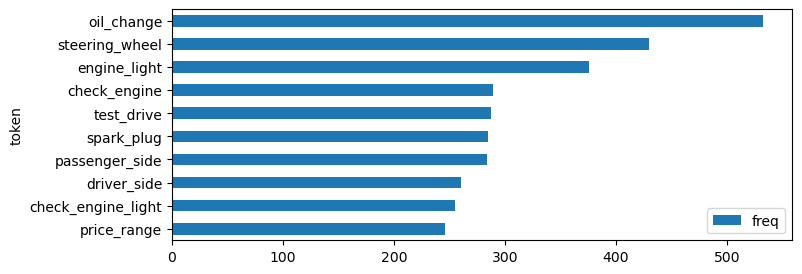

In [98]:
# 자동차 범주에서 가장 자주 언급되는 명사구 확인하기
count_words(df, 'noun_phrases').head(10).plot(kind='barh',  figsize=(8,3)).invert_yaxis()

#### 결과 유지

In [101]:
# 추출된 파이써너 리스트를 공백으로 구분한 문자열로 직렬화
df[nlp_columns] = df[nlp_columns].applymap(lambda items: ' '.join(items))

con = sqlite3.connect(db_name)
df.to_sql('posts_nlp', con, index=False, if_exists='replace')
con.close()

### 더 알아보기

#### 언어 감지

In [102]:
# 모델 다운로드
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz

--2023-08-04 17:23:15--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.86.207.52, 99.86.207.41, 99.86.207.39, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.86.207.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 938013 (916K) [binary/octet-stream]
Saving to: 'lid.176.ftz'

     0K .......... .......... .......... .......... ..........  5% 3.56M 0s
    50K .......... .......... .......... .......... .......... 10% 8.60M 0s
   100K .......... .......... .......... .......... .......... 16% 7.18M 0s
   150K .......... .......... .......... .......... .......... 21% 12.1M 0s
   200K .......... .......... .......... .......... .......... 27% 3.26M 0s
   250K .......... .......... .......... .......... .......... 32% 2.12M 0s
   300K .......... .......... .......... .......... .......... 38% 1.60M 0s
   350K .......... .......... .......... .......... ...

In [129]:
# 모델 가져오기
load_model = FastText.load_model('lid.176.ftz')

AttributeError: type object 'FastText' has no attribute 'load_model'